In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import time

# custom libs
import sys
sys.path.append("..")
from src.simulations import simulate_curves, generate_coeffs
from src.dynamicFPC import K_dFPC, W_dFPC
from src.forecasting import overall_Lnorm

In [3]:
def print_truncated(i, step):
    if i % step == 0:
        print(f"\t {i}")

In [4]:
doc_path = "../../densities4risk_doc/Figures/"

# Sample data

In [5]:
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
phis = generate_coeffs(d) # AR(1) model coefficients
variance = 1.5

Y, X, mEps = simulate_curves(
                        n,
                        nt,
                        u,
                        phis, 
                        variances=np.full(len(phis), variance)
                        )

In [4]:
T, n = X.shape
x_support = np.arange(T)  

fig = go.Figure()

color_original = "#06d6a0"
color_observed = "#8338ec"

# Unobserved curves (X)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=X[:, j],
            mode="lines",
            line=dict(color=color_original, dash="dash"),
            opacity=0.6,
            showlegend=(j == 0),
            name="Unobserved"
        )
    )

# Observed curves (Y)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=Y[:, j],
            mode="lines",
            line=dict(color=color_observed),
            opacity=0.6,
            showlegend=(j == 0),
            name="Observed"
        )
    )

# Mean curve
fig.add_trace(
    go.Scatter(
        x=x_support,
        y=np.mean(Y, axis=1),
        mode="lines",
        line=dict(color="black", width=3),
        name="Mean(Y)"
    )
)

fig.update_layout(
    title=f"{n} Curves: Original ({color_original}) and Observed ({color_observed})",
    xaxis_title="Index",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()


# Simulations

## Estimating dimensions

In [6]:
# -----------------------
# WdFPC configuration
# -----------------------
WdFPC_kwargs = {
    "wavelet": "db2",
    "N": 3,
    "p": 5,
    "d": d,
    "nt": nt,
}

# -----------------------
# KdFPC configuration
# -----------------------
KdFPC_kwargs = {
    "lag_max": 5,
    "alpha": 0.10,
    "du": 0.05,
    "B": 1000,
    "p": 5,
    "m": nt,
    "u": u,
    "select_ncomp": False,
    "dimension": d,
}

In [ ]:
# Repetitions
R = 10_000

# Variable
D = 10

timings = {}
for d in range(1, D+1):
    print(f">>>Initiating simulations for d={d}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    phis = generate_coeffs(d)

    for r in range(R):
        print_truncated(r,200)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = d
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = d
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings[d] = df_timing

In [32]:
df = pd.DataFrame()

for k in timings.keys():
    df0 = timings[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [39]:
df.columns = ["WdFPC", "KdFPC", "d"]

In [46]:
print(f"Median of {R:,} simulations for estimating each d of {D} dimensions for {n} curves")
df.groupby("d").median()

Median of 10,000 simulations for estimating each d of 10 dimensions for 100 curves


,WdFPC,KdFPC
d,,
1,0.063722,0.004133
2,0.063787,0.003703
3,0.063029,0.004528
4,0.059256,0.003807
5,0.060620,0.004483
6,0.060661,0.004542
7,0.055070,0.003470
8,0.060443,0.004564
9,0.059066,0.004598


In [35]:
df.to_excel("../data/processed/time_simulation_dim.xlsx", index=False)

## Changing number of curves

In [55]:
# Repetitions
R = 1_000

# Accuracy measures
norms = ["L1", "L2", "LINF"]

# Variable
N = np.append(
            np.array([100,250]), 
            np.arange(500,3500,500)
            )

D = 4
phis = generate_coeffs(D)
timings_n = {}
accuracy_n = {}
for n in N:
    print(f">>>Initiating simulations for n={n}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    
    wd_accuracy = np.zeros([R,len(norms)])
    kd_accuracy = np.zeros([R,len(norms)])
    
    for r in range(R):
        print_truncated(r,20)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = D
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = D
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

        # ---- Computes L norms ----
        for i, norm in enumerate(norms):
            w_norm = overall_Lnorm(pd.DataFrame(Y), pd.DataFrame(WdFPC_model.Yhat), n_test = Y.shape[1], norm = norm)
            k_norm = overall_Lnorm(pd.DataFrame(Y), pd.DataFrame(KdFPC_model.fitted_values), n_test = Y.shape[1], norm = norm)

            wd_accuracy[r, i] = w_norm
            kd_accuracy[r, i] = k_norm

    # ---- Timing ----
    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings_n[n] = df_timing

    # ---- Accuracy ----
    accuracy_n[n] = {
                    "WdFPC": pd.DataFrame(wd_accuracy, columns=norms),
                    "KdFPC": pd.DataFrame(kd_accuracy, columns=norms)
            }

>>>Initiating simulations for n=100
	 0


c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:613: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet)
c:\Users\user\Projetos\densities4risk\notebooks\..\src\dynamicFPC.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


	 20
	 40
	 60
	 80
	 100
	 120
	 140
	 160
	 180
	 200
	 220
	 240
	 260
	 280
	 300
	 320
	 340
	 360
	 380
	 400
	 420
	 440
	 460
	 480
	 500
	 520
	 540
	 560
	 580
	 600
	 620
	 640
	 660
	 680
	 700
	 720
	 740
	 760
	 780
	 800
	 820
	 840
	 860
	 880
	 900
	 920
	 940
	 960
	 980
>>>Initiating simulations for n=250
	 0
	 20
	 40
	 60
	 80
	 100
	 120
	 140
	 160
	 180
	 200
	 220
	 240
	 260
	 280
	 300
	 320
	 340
	 360
	 380
	 400
	 420
	 440
	 460
	 480
	 500
	 520
	 540
	 560
	 580
	 600
	 620
	 640
	 660
	 680
	 700
	 720
	 740
	 760
	 780
	 800
	 820
	 840
	 860
	 880
	 900
	 920
	 940
	 960
	 980
>>>Initiating simulations for n=500
	 0
	 20
	 40
	 60
	 80
	 100
	 120
	 140
	 160
	 180
	 200
	 220
	 240
	 260
	 280
	 300
	 320
	 340
	 360
	 380
	 400
	 420
	 440
	 460
	 480
	 500
	 520
	 540
	 560
	 580
	 600
	 620
	 640
	 660
	 680
	 700
	 720
	 740
	 760
	 780
	 800
	 820
	 840
	 860
	 880
	 900
	 920
	 940
	 960
	 980
>>>Initiating simulations for n=1000
	 0
	 20
	 40

In [128]:
dfs = []

for n, methods in accuracy_n.items():
    for method, df_ in methods.items():
        tmp = (
            df_
            .assign(n=n, Method=method)
            .reset_index(names="rep")
            .melt(
                id_vars=["n", "Method", "rep"],
                var_name="metric",
                value_name="value"
            )
        )
        dfs.append(tmp)

df_accuracy_long = pd.concat(dfs, ignore_index=True)

In [130]:
import json
import numpy as np

def dict_to_json_safe(results_dict):
    out = {}

    for n, methods in results_dict.items():
        n = int(n)  # np.int64 → int
        out[n] = {}

        for method, df in methods.items():
            out[n][method] = {
                "columns": list(df.columns),
                "data": df.to_dict(orient="records")
            }

    return out

In [ ]:
json_safe = dict_to_json_safe(accuracy_n)

with open("../data/processed/time_simulation_accuracy.json", "w") as f:
    json.dump(json_safe, f, indent=2)

{100: {'WdFPC': {'columns': ['L1', 'L2', 'LINF'],
   'data': [{'L1': 190.73315, 'L2': 12.713315, 'LINF': 1.215654},
    {'L1': 189.268579, 'L2': 12.845387, 'LINF': 1.26045},
    {'L1': 178.611245, 'L2': 11.402804, 'LINF': 0.957554},
    {'L1': 176.596645, 'L2': 11.547604, 'LINF': 1.027526},
    {'L1': 190.011066, 'L2': 12.480943, 'LINF': 1.135024},
    {'L1': 167.259275, 'L2': 10.858211, 'LINF': 0.944985},
    {'L1': 192.181449, 'L2': 12.258642, 'LINF': 1.006367},
    {'L1': 185.422882, 'L2': 12.105358, 'LINF': 1.046966},
    {'L1': 206.452471, 'L2': 13.599199, 'LINF': 1.222863},
    {'L1': 204.211005, 'L2': 13.116193, 'LINF': 1.09203},
    {'L1': 159.623123, 'L2': 10.601119, 'LINF': 0.99308},
    {'L1': 195.942151, 'L2': 13.328348, 'LINF': 1.245932},
    {'L1': 169.31285, 'L2': 11.119301, 'LINF': 1.021184},
    {'L1': 203.150215, 'L2': 13.225353, 'LINF': 1.16838},
    {'L1': 155.528883, 'L2': 10.141899, 'LINF': 0.923703},
    {'L1': 182.386494, 'L2': 11.985954, 'LINF': 1.092286},
    

In [ ]:
# Treat accuracy data
# records = []

# for n, methods in accuracy_n.items():
#     for method, df in methods.items():
#         for metric in df.columns:
#             records.append({
#                 "n": int(n),
#                 "method": method,
#                 "metric": metric,
#                 "value": df.loc[0, metric]
#             })

# df_accuracy_long = pd.DataFrame(records).sort_values(by=["n", "metric"])

In [57]:
df = pd.DataFrame()

for k in timings_n.keys():
    df0 = timings_n[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [64]:
df.columns = ["WdFPC", "KdFPC", "n"]
print(f"Median of {R:,} simulations for estimating n of {N} curves with dimension {4}")
df.groupby("n").median()

Median of 1,000 simulations for estimating n of [ 100  250  500 1000 1500 2000 2500 3000] curves with dimension 4


,WdFPC,KdFPC
n,,
100,0.020405,0.002865
250,0.029090,0.019014
500,0.048041,0.082663
1000,0.094255,0.408761
1500,0.151931,1.130965
2000,0.229502,2.589593
2500,0.338074,4.849011
3000,0.457297,8.167511


In [139]:
df_accuracy_long

,n,Method,rep,metric,value
0,100,WdFPC,0,L1,190.733150
1,100,WdFPC,1,L1,189.268579
2,100,WdFPC,2,L1,178.611245
3,100,WdFPC,3,L1,176.596645
4,100,WdFPC,4,L1,190.011066
...,...,...,...,...,...
47995,3000,KdFPC,995,LINF,0.978165
47996,3000,KdFPC,996,LINF,0.996438
47997,3000,KdFPC,997,LINF,0.995855
47998,3000,KdFPC,998,LINF,0.986016


In [141]:
df_accuracy_comparison = df_accuracy_long.pivot(
    index=["n", "rep", "metric"],
    columns="Method",
    values="value"
    ).reset_index()

df_accuracy_comparison

Method,n,rep,metric,KdFPC,WdFPC
0,100,0,L1,189.904540,190.733150
1,100,0,L2,12.409445,12.713315
2,100,0,LINF,1.127031,1.215654
3,100,1,L1,186.973632,189.268579
4,100,1,L2,12.654114,12.845387
...,...,...,...,...,...
23995,3000,998,L2,12.046057,12.120186
23996,3000,998,LINF,0.986016,0.959791
23997,3000,999,L1,189.953850,190.306696
23998,3000,999,L2,12.075319,12.147629


In [134]:
df.to_excel("../data/processed/time_simulation_n_2.xlsx", index=False)
df_accuracy_long.to_excel("../data/processed/time_simulation_n_2_accuracy.xlsx", index=False)

In [106]:
df_long = df.melt(
    id_vars="n",
    value_vars=["WdFPC", "KdFPC"],
    var_name="Method",
    value_name="Time"
)

# make sure n is categorical
df_long["n"] = df_long["n"].astype(str)

In [108]:
df_long = df_long.drop(df_long.groupby(["n","Method"])["Time"].idxmax().values) # retira valores extremos para gráfico de violino/boxplot

In [103]:
palette = {
    # "WdFPC": "#8338ec",
    "WdFPC": "#c77dff",
    "KdFPC": "#4ae867",  
}

<Figure size 1000x500 with 0 Axes>

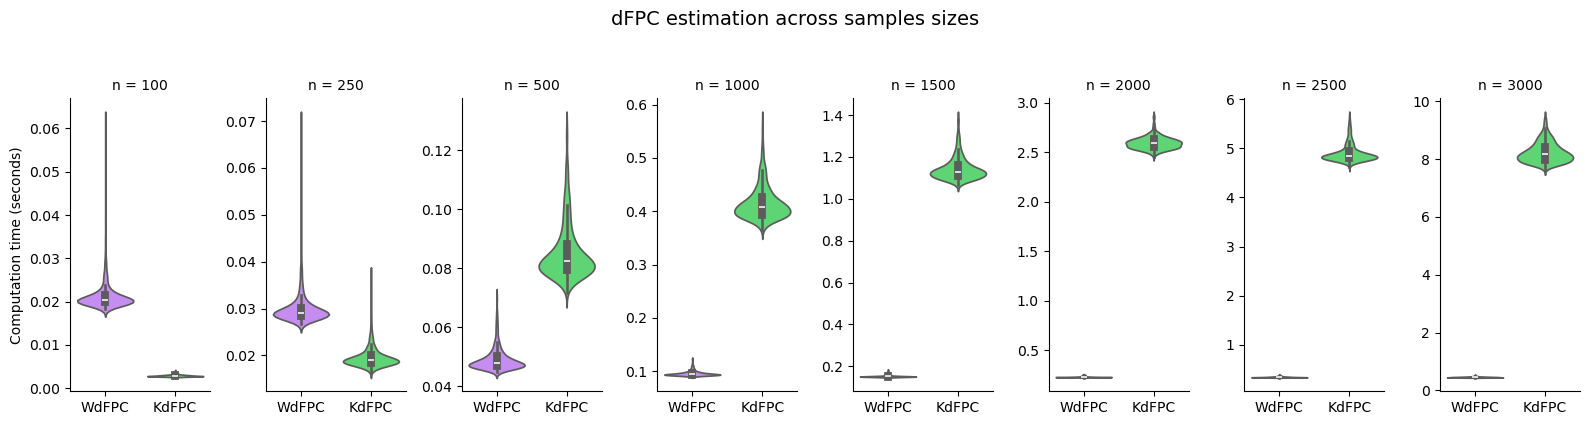

In [104]:
plt.figure(figsize=(10, 5))

# sns.violinplot(
#     data=df_long,
#     x="n",
#     y="Time",
#     hue="Method",
#     split=False,   # keep violins side-by-side, not split
#     inner="quartile",
#     cut=0
# )

g = sns.catplot(
    data=df_long,
    x="Method",
    y="Time",
    col="n",
    kind="violin",
    # kind="box",
    hue="Method",
    # kind="violin",
    # inner="quartile",
    # cut=0,
    sharey=False,
    height=4,
    aspect=0.5,
    palette=palette
)
for ax in g.axes.flatten():
    ax.set_xlabel("")   # remove "Method"

g.figure.suptitle(
    "dFPC estimation across samples sizes",
    fontsize=14,
    y=1.05
)
g.set_ylabels("Computation time (seconds)")

plt.tight_layout()
plt.savefig(''.join([doc_path, 'sim_n_boxplot.png']))

C:\Users\user\AppData\Local\Temp\ipykernel_10984\453438103.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


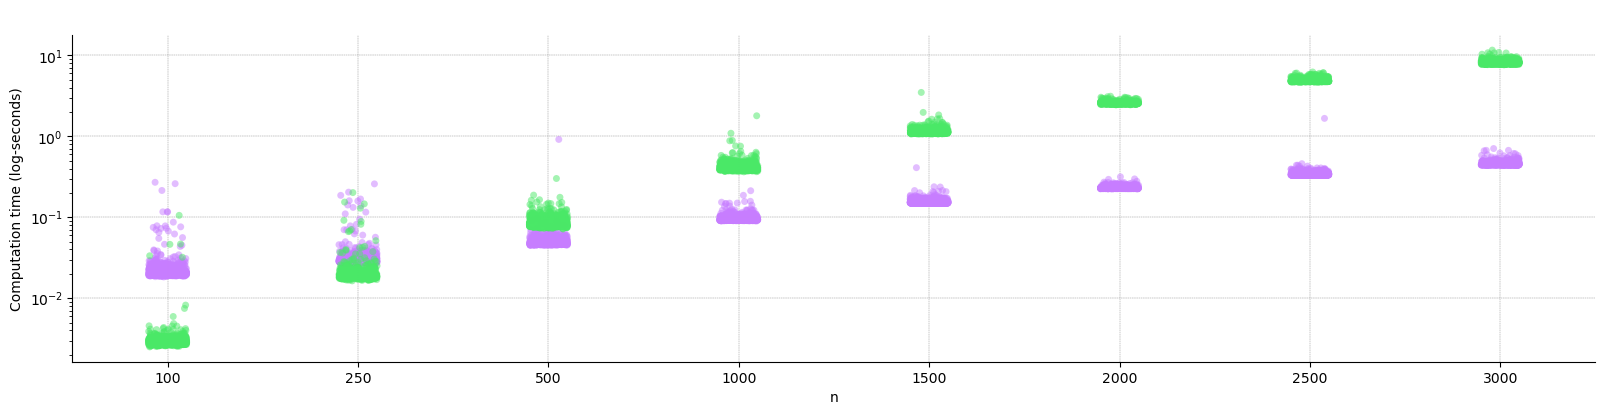

In [107]:
g = sns.catplot(
    data=df_long,
    x="n",
    y="Time",
    hue="Method",
    height=4,
    aspect=4,
    palette=palette,
    legend=False,
    alpha=0.5
)

# g.figure.suptitle(
#     "dFPC estimation across samples sizes",
#     fontsize=14,
#     y=1.05
# )
g.set_ylabels("Computation time (log-seconds)")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    frameon=False,
    title=None
)

plt.yscale("log")
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.savefig(''.join([doc_path, 'sim_n_scatter.png']))